# BERT Fine-Tuning

Binary sentiment classification using `bert-base-uncased` fine-tuned with HuggingFace Trainer.

Prerequisite: run `00_preprocessing.ipynb` first.

In [1]:
import warnings
import os

# Suppress MPS pin_memory and checkpoint key warnings
warnings.filterwarnings("ignore", message=".*pin_memory.*")
warnings.filterwarnings("ignore", message=".*IProgress.*")
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Load data and split

In [2]:
df = pd.read_csv('../data/reviews_extraidas.csv')
df['label'] = (df['Y'] > 5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df['X'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 435, Test: 109


## Prepare datasets

In [3]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts.iloc[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long),
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ReviewDataset(X_train, y_train, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 435, Test: 109


## Fine-tune BERT

In [4]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
    }

training_args = TrainingArguments(
    output_dir='/tmp/bert_checkpoints',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

The following layers were not sharded: bert.embeddings.position_embeddings.weight, classifier.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.bias, classifier.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.pooler.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.bias, bert.encoder.la

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.642632,0.619734,0.633028,0.636432
2,0.402624,0.469187,0.761468,0.764615
3,0.181631,0.573892,0.798165,0.799062


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=165, training_loss=0.4615014899860729, metrics={'train_runtime': 80.6516, 'train_samples_per_second': 16.181, 'train_steps_per_second': 2.046, 'total_flos': 171679963622400.0, 'train_loss': 0.4615014899860729, 'epoch': 3.0})

## Evaluation

In [5]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print()
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.7706
F1 (macro): 0.7627
F1 (weighted): 0.7734

              precision    recall  f1-score   support

    Negative       0.85      0.76      0.81        68
    Positive       0.67      0.78      0.72        41

    accuracy                           0.77       109
   macro avg       0.76      0.77      0.76       109
weighted avg       0.78      0.77      0.77       109



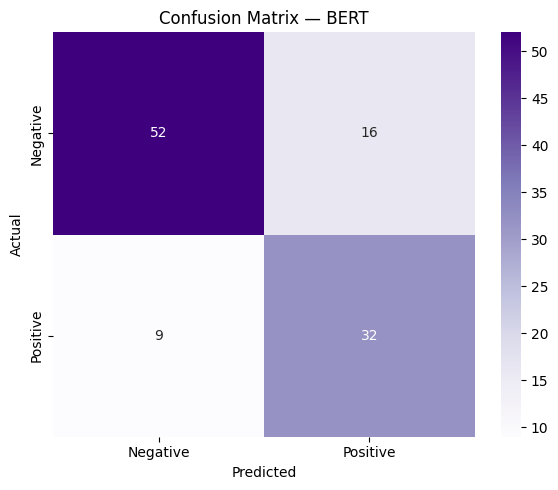

In [6]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Inference on new reviews

In [7]:
samples = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either.",
]

label_map = {0: 'Negative', 1: 'Positive'}
model_cpu = model.cpu()
model_cpu.eval()

for text in samples:
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')

    with torch.no_grad():
        logits = model_cpu(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0]
        pred = logits.argmax(dim=1).item()

    print(f"{label_map[pred]:>8s} ({probs[pred]:.2%})  |  {text}")

Positive (88.47%)  |  This movie was absolutely amazing! I loved every moment of it.
Negative (84.99%)  |  Terrible film. Waste of time and money. Do not watch.
Positive (67.08%)  |  It was okay, nothing special but not bad either.
